## Import libraries

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from scipy.special import comb

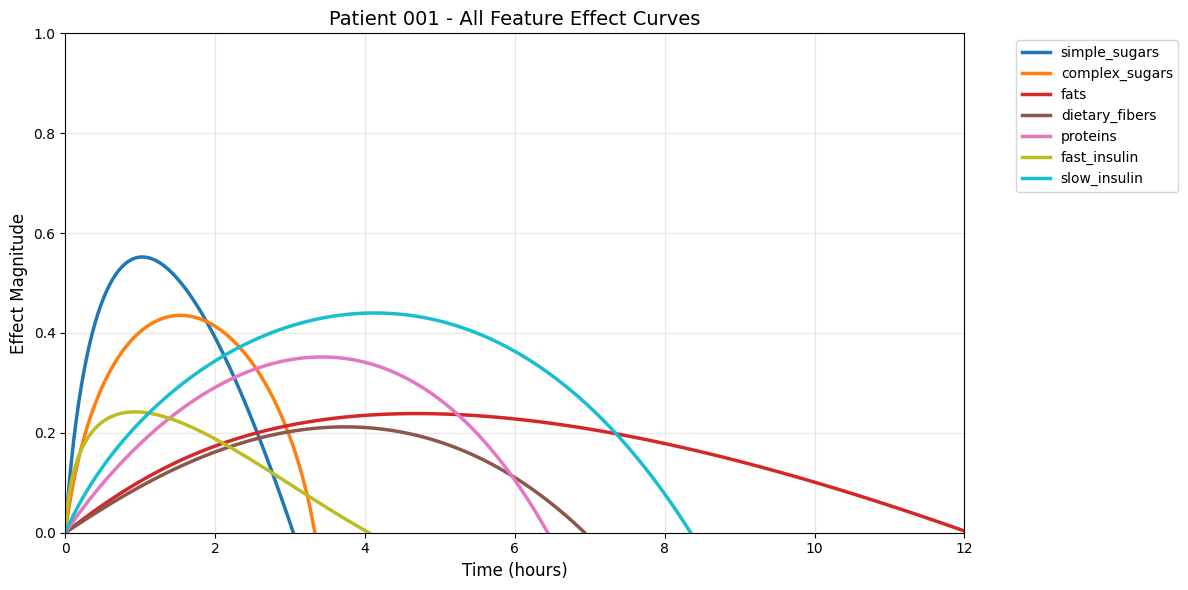

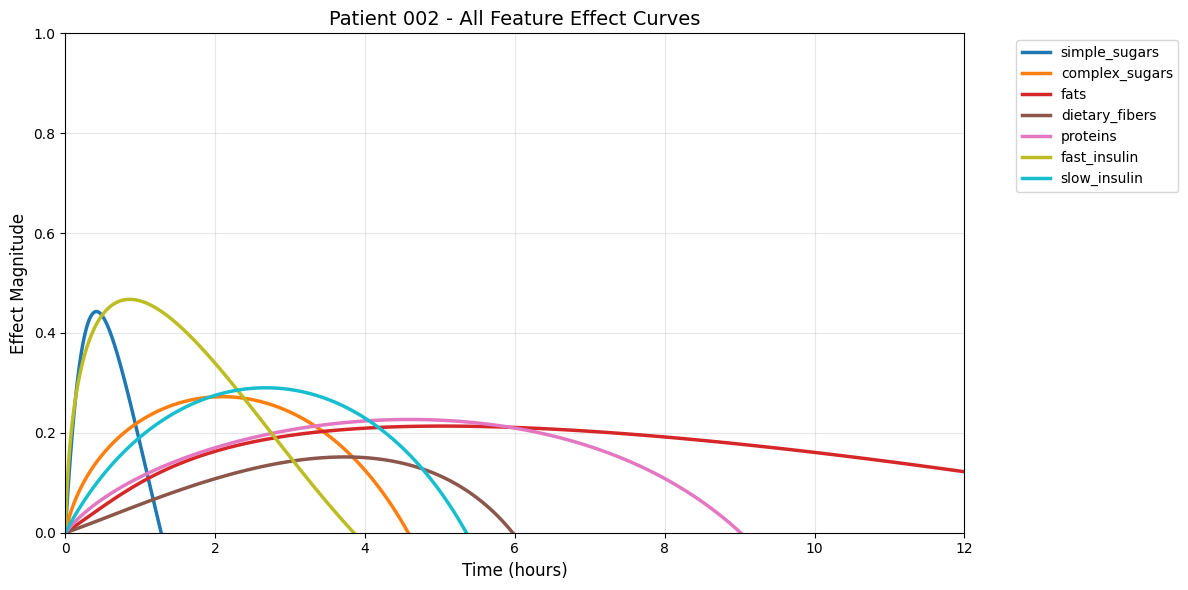

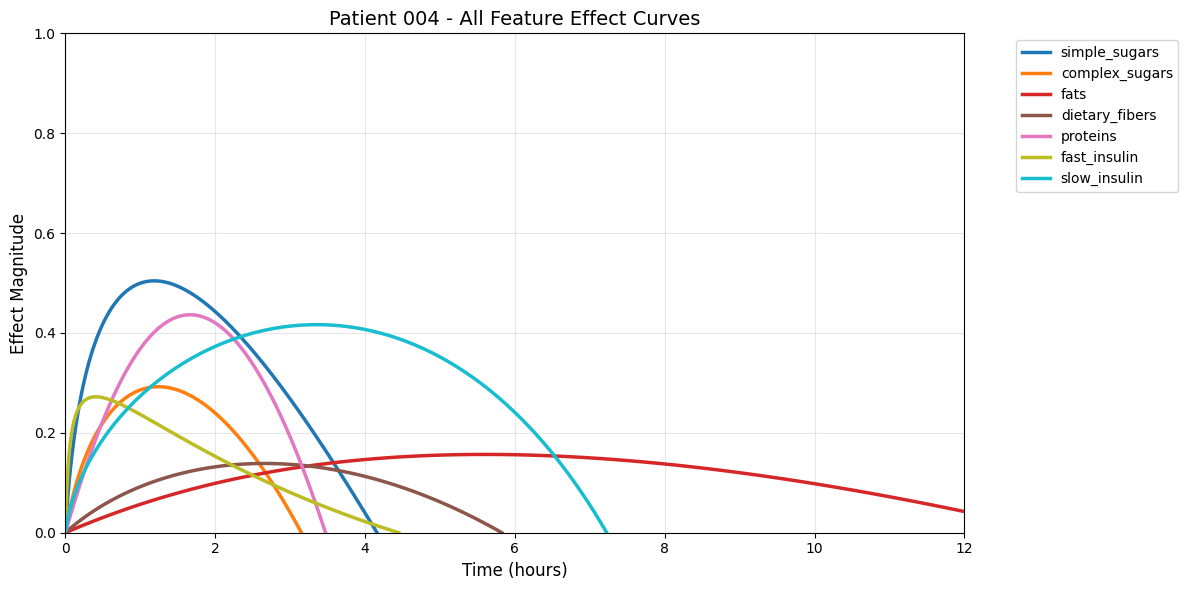

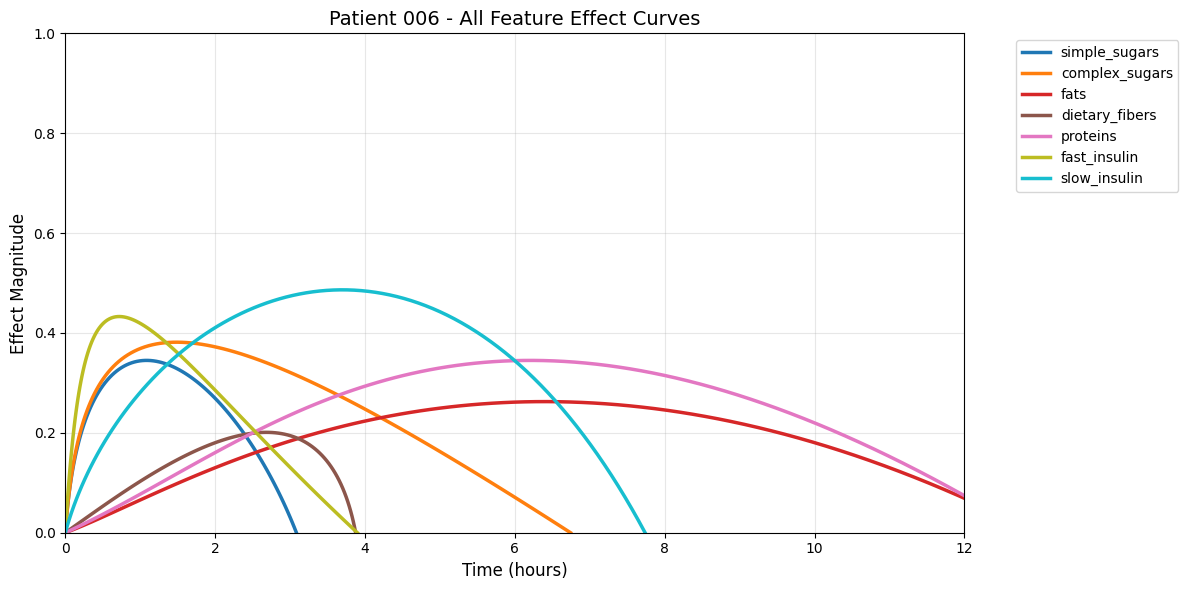

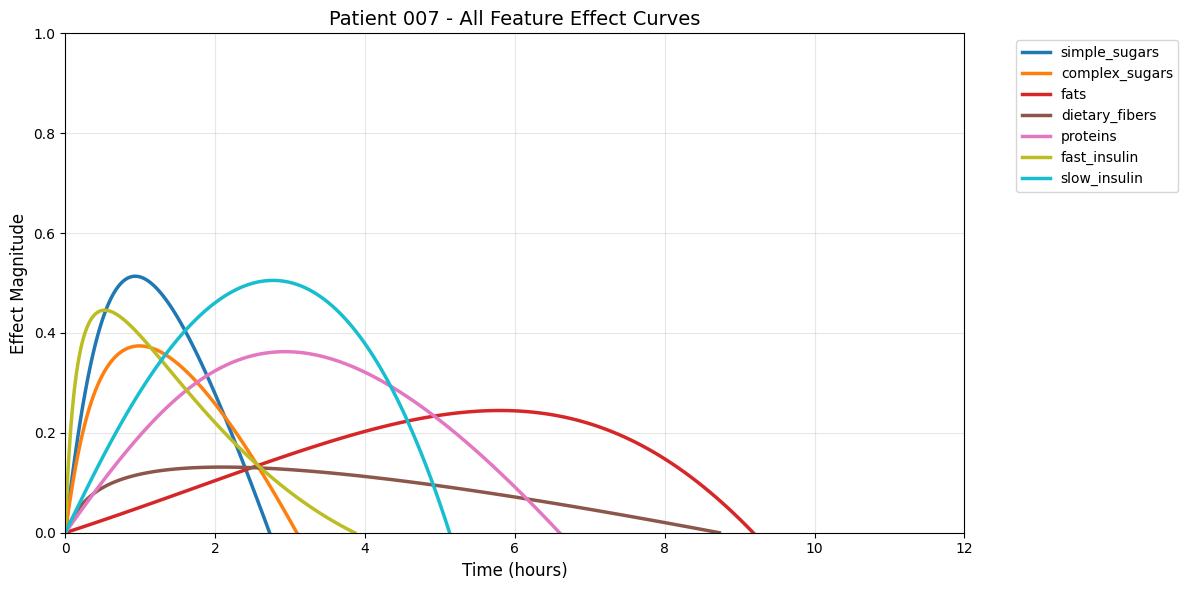

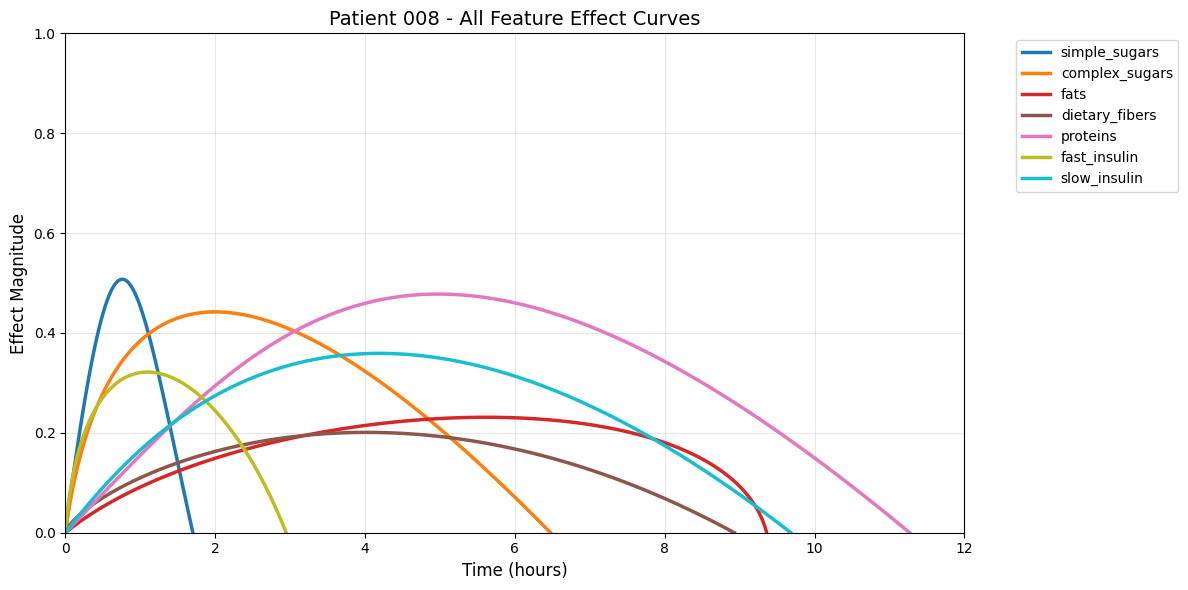

In [37]:
def bernstein_poly(i, n, t):
    return comb(n, i) * (t**i) * ((1-t)**(n-i))

def bezier_curve(points, num=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num)
    curve = np.zeros((num, 2))
    
    for i, point in enumerate(points):
        curve += np.outer(bernstein_poly(i, n, t), point)
    
    return curve

# Load parameters
with open('parameters/patient_bezier_params.json', 'r') as f:
    params = json.load(f)

features = ['simple_sugars', 'complex_sugars', 'fats', 'dietary_fibers', 'proteins', 'fast_insulin', 'slow_insulin']

# Create output directory
os.makedirs('visualizations', exist_ok=True)

# Color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(features)))
color_map = dict(zip(features, colors))

# Plot by patient - all features in one plot
for patient, feature_params in params.items():
    plt.figure(figsize=(12, 6))
    
    # Plot each feature
    for feature in features:
        if feature in feature_params:
            # Reshape parameters into control points
            control_points = np.array(feature_params[feature]).reshape(-1, 2)
            
            # Generate and plot Bezier curve
            curve = bezier_curve(control_points, num=100)
            plt.plot(curve[:, 0], curve[:, 1], '-', linewidth=2.5, 
                    label=feature, color=color_map[feature])
    
    plt.title(f'Patient {patient} - All Feature Effect Curves', fontsize=14)
    plt.xlabel('Time (hours)', fontsize=12)
    plt.ylabel('Effect Magnitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 12)  # Limit x-axis to 12 hours for better visibility
    plt.ylim(0, 1)   # Normalize y-axis
    
    # Add legend with better positioning
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

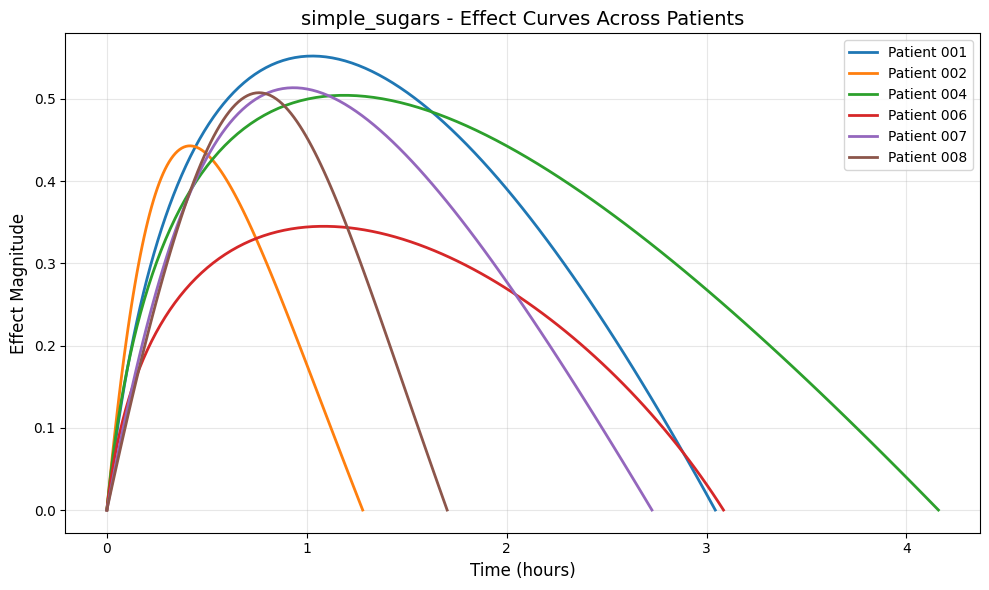

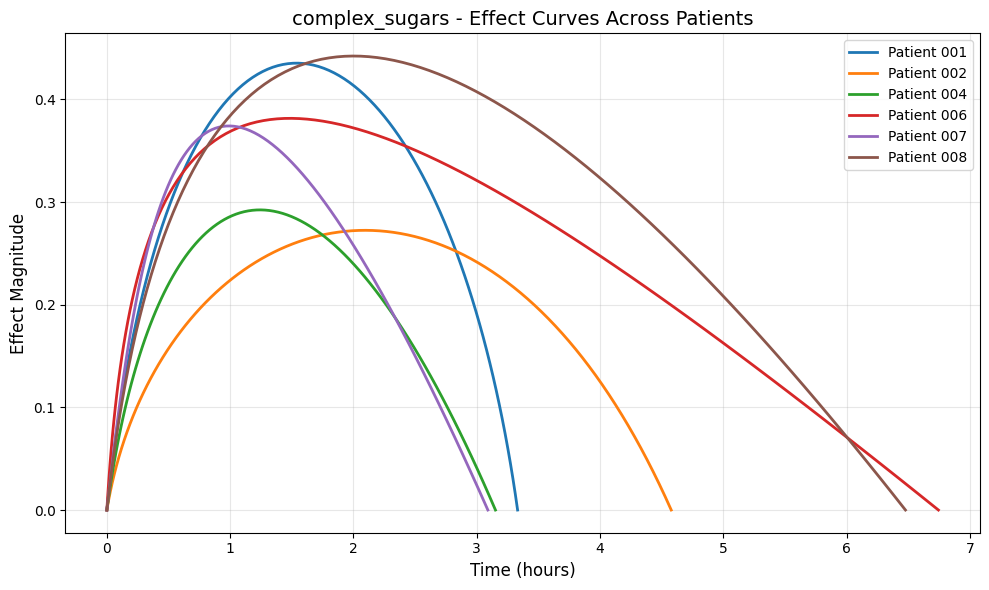

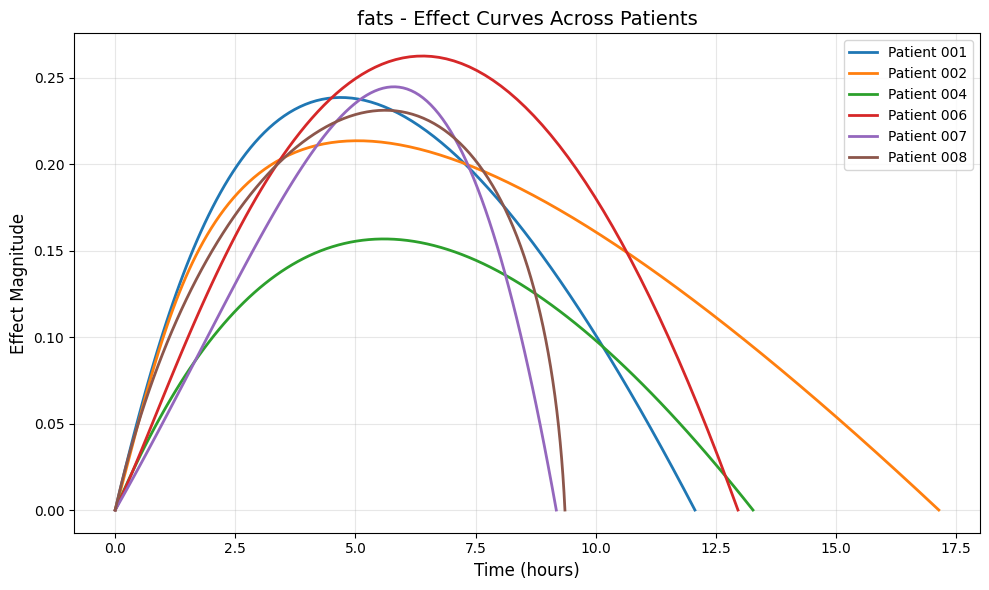

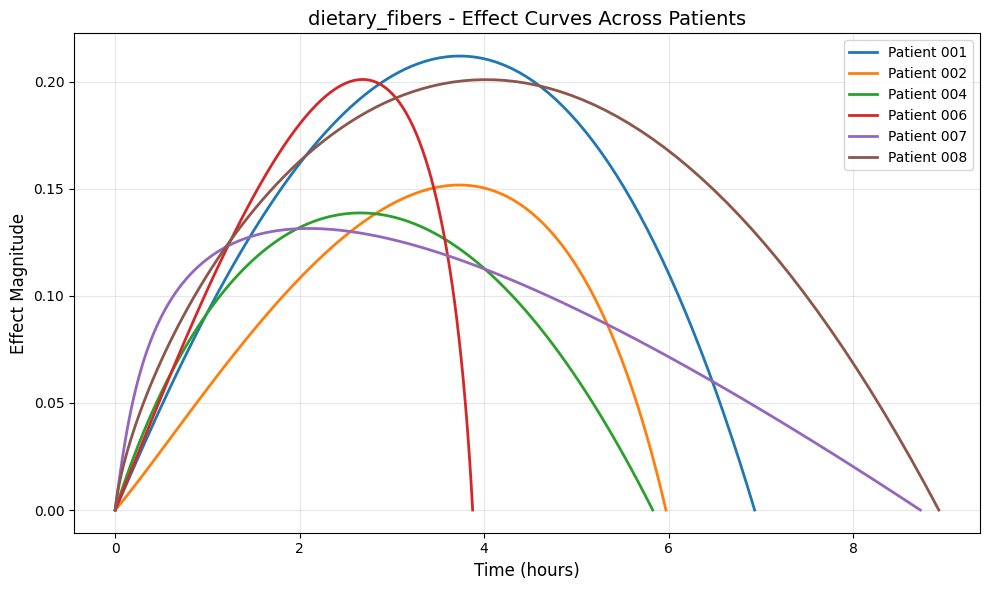

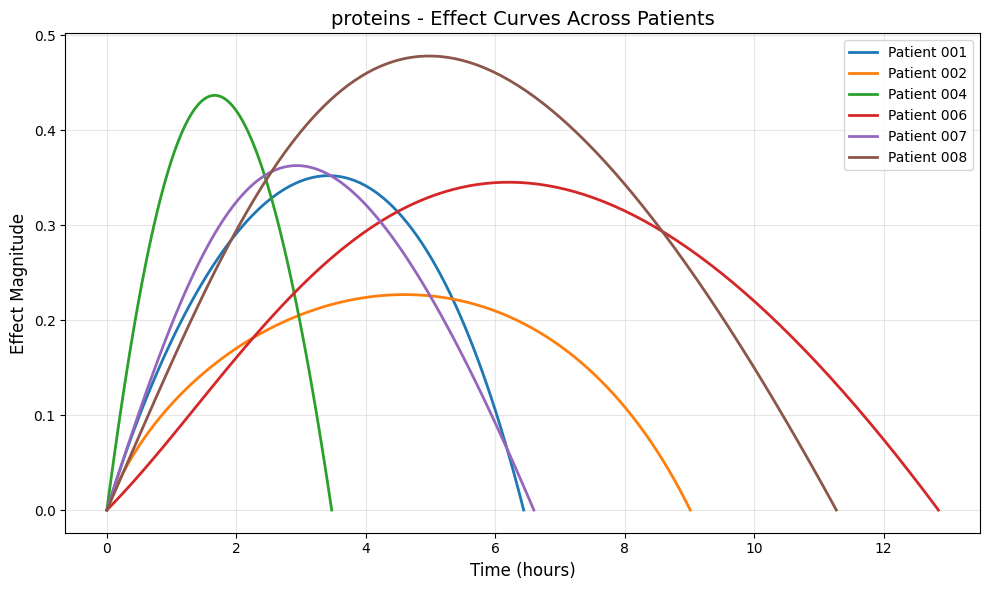

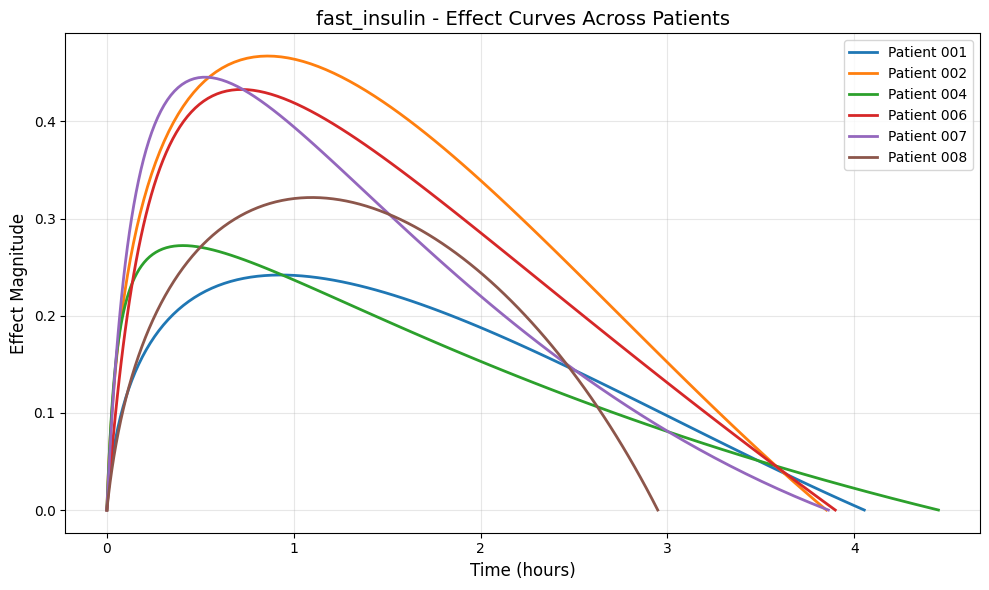

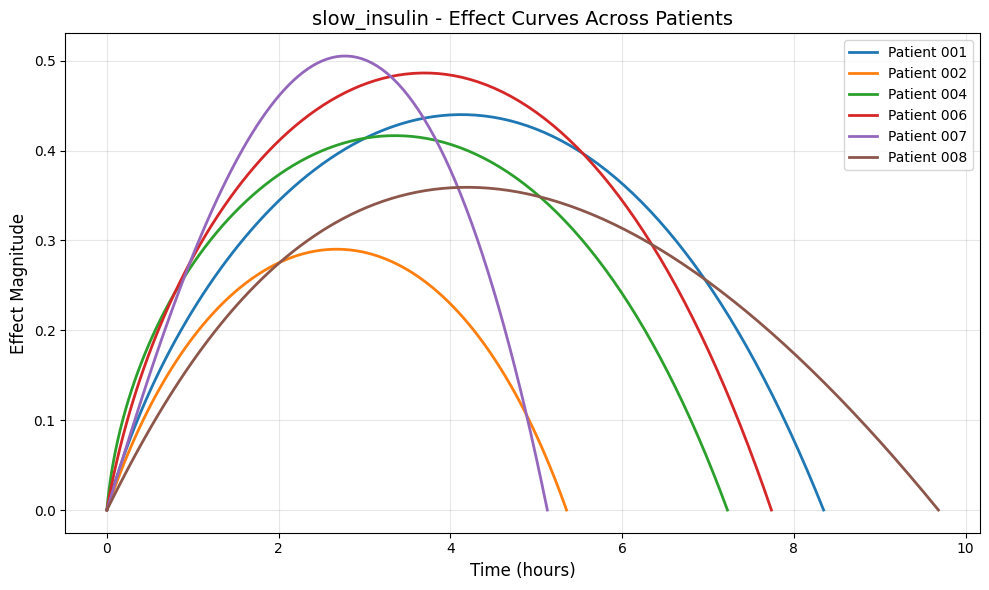

In [38]:
# Comparative visualization across patients
for feature in features:
    plt.figure(figsize=(10, 6))
    
    for patient, feature_params in params.items():
        if feature in feature_params:
            control_points = np.array(feature_params[feature]).reshape(-1, 2)
            curve = bezier_curve(control_points, num=100)
            plt.plot(curve[:, 0], curve[:, 1], '-', linewidth=2, label=f'Patient {patient}')
    
    plt.title(f'{feature} - Effect Curves Across Patients', fontsize=14)
    plt.xlabel('Time (hours)', fontsize=12)
    plt.ylabel('Effect Magnitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [39]:
df = pd.read_csv('evaluation_metrics_bezier.csv')
df['Patient'] = df['Patient'].astype(str)

In [40]:
# Create aggregated data for the table
agg_data = df.groupby(['Approach', 'Prediction Horizon'])['RMSE'].agg(['mean', 'std']).reset_index()

# Pivot the data to get approaches as columns
pivot_data = agg_data.pivot(index='Prediction Horizon', columns='Approach', values=['mean', 'std'])

# Format the table in LaTeX style with mean±std in the same cell
latex_content = "\\begin{table}[h]\n"
latex_content += "\\centering\n"
latex_content += "\\begin{tabular}{c|c|c}\n"
latex_content += "\\hline\n"
latex_content += "Prediction & pixtral-large-latest & nollm \\\\\n"
latex_content += "Horizon & RMSE (mean $\\pm$ std) & RMSE (mean $\\pm$ std) \\\\\n"
latex_content += "\\hline\n"

for ph in sorted(pivot_data.index.unique()):
    pixtral_mean = pivot_data[('mean', 'pixtral-large-latest')].loc[ph]
    pixtral_std = pivot_data[('std', 'pixtral-large-latest')].loc[ph]
    nollm_mean = pivot_data[('mean', 'nollm')].loc[ph]
    nollm_std = pivot_data[('std', 'nollm')].loc[ph]
    latex_content += f"{ph} & {pixtral_mean:.2f} $\\pm$ {pixtral_std:.2f} & {nollm_mean:.2f} $\\pm$ {nollm_std:.2f} \\\\\n"

latex_content += "\\hline\n"
latex_content += "\\end{tabular}\n"
latex_content += "\\caption{RMSE comparison between approaches across different prediction horizons}\n"
latex_content += "\\label{tab:rmse_comparison}\n"
latex_content += "\\end{table}"

# Save to .tex file
with open('rmse_comparison_table.tex', 'w') as f:
    f.write(latex_content)

# Display the regular DataFrame for reference
df

,Approach,Prediction Horizon,Patient,Day,Hour,RMSE
0,pixtral-large-latest,6,1,4,0,4.841661
1,pixtral-large-latest,6,1,4,1,4.039551
2,pixtral-large-latest,6,1,4,2,5.503225
3,pixtral-large-latest,6,1,4,3,8.766756
4,pixtral-large-latest,6,1,4,4,12.354036
...,...,...,...,...,...,...
2301,nollm,24,8,4,3,9.155331
2302,nollm,24,8,4,4,17.189748
2303,nollm,24,8,4,5,20.475519
2304,nollm,24,8,4,6,47.702456
